In [1]:
# Preprocessor classes are used to load, transform, and augment audio samples for use in a machine learing model
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor, CnnPreprocessor

#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random
import subprocess

In [2]:
#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# helper function for displaying a sample as an image
def show_tensor(sample):
    plt.imshow((sample['X'][0,:,:]/2+0.5)*-1,cmap='Greys',vmin=-1,vmax=0)
    plt.show()

In [3]:
torch.manual_seed(0)
random.seed(0)

In [4]:
subprocess.run(['curl','https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz','-L', '-o','woodcock_labeled_data.tar.gz']) # Download the data
subprocess.run(["tar","-xzf", "woodcock_labeled_data.tar.gz"]) # Unzip the downloaded tar.gz file
subprocess.run(["rm", "woodcock_labeled_data.tar.gz"])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     7    0     7    0     0      6      0 --:--:--  0:00:01 --:--:--     6
100 4031k  100 4031k    0     0  1697k      0  0:00:02  0:00:02 --:--:-- 3502k


CompletedProcess(args=['rm', 'woodcock_labeled_data.tar.gz'], returncode=0)

In [10]:
#load Specky output: a table of labeled audio files
specky_table = pd.read_csv(Path("woodcock_labeled_data/woodcock_labels.csv"))
#update the paths to the audio files
specky_table.filename = ['./woodcock_labeled_data/'+f for f in specky_table.filename]

from opensoundscape.annotations import categorical_to_one_hot
one_hot_labels, classes = categorical_to_one_hot(specky_table[['woodcock']].values)
labels = pd.DataFrame(index=specky_table['filename'],data=one_hot_labels,columns=classes)
labels.head()

,absent,present
filename,,
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,0,1
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,1,0
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,0,1
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,0,1
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,0,1


A Preprocessor must be initialized with a very specific dataframe:

- the index of the dataframe provides paths to audio samples
- the columns are the class names
- the values are 0 (absent/False) or 1 (present/True) for each sample and each class.

In [6]:
from opensoundscape.preprocess.preprocessors import CnnPreprocessor

preprocessor = CnnPreprocessor(labels)

In [7]:
preprocessor[0]

{'X': tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0191, -0.0078,  0.0653],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0958,  0.0501,  0.0597],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.3639,  0.1509,  0.0387],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ..., -0.0090, -0.0230,  0.0743],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.1073,  0.0300,  0.0806],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.3479,  0.1474,  0.0241],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0079, -0.0237,  0.0630],
          [ 0.0000,  0.

Each Preprocessor class has two attributes, `preprocessor.pipeline` and `preprocessor.actions`. Pipelines are comprised of Actions.

In [8]:
preprocessor.pipeline

In [11]:
# create a new instance of a CnnPreprocessor
preprocessor = AudioToSpectrogramPreprocessor(labels)

# print all Actions that have been added to the preprocessor
# (Note that this is not the pipeline, just a collection of available actions)
preprocessor.actions.list_actions()

['load_audio',
 'trim_audio',
 'to_spec',
 'bandpass',
 'to_img',
 'to_tensor',
 'normalize']

In [12]:
preprocessor.actions.to_spec

In [13]:
preprocessor.actions.to_spec.params

{}

In [14]:
preprocessor.actions.to_spec.set(window_samples=256)

In [15]:
print(preprocessor.actions.load_audio.params)

{'sample_rate': None}


original pipeline:

new pipeline:

we now have a preprocessor that returns Spectrograms instead of Tensors:
<class 'opensoundscape.spectrogram.Spectrogram'>


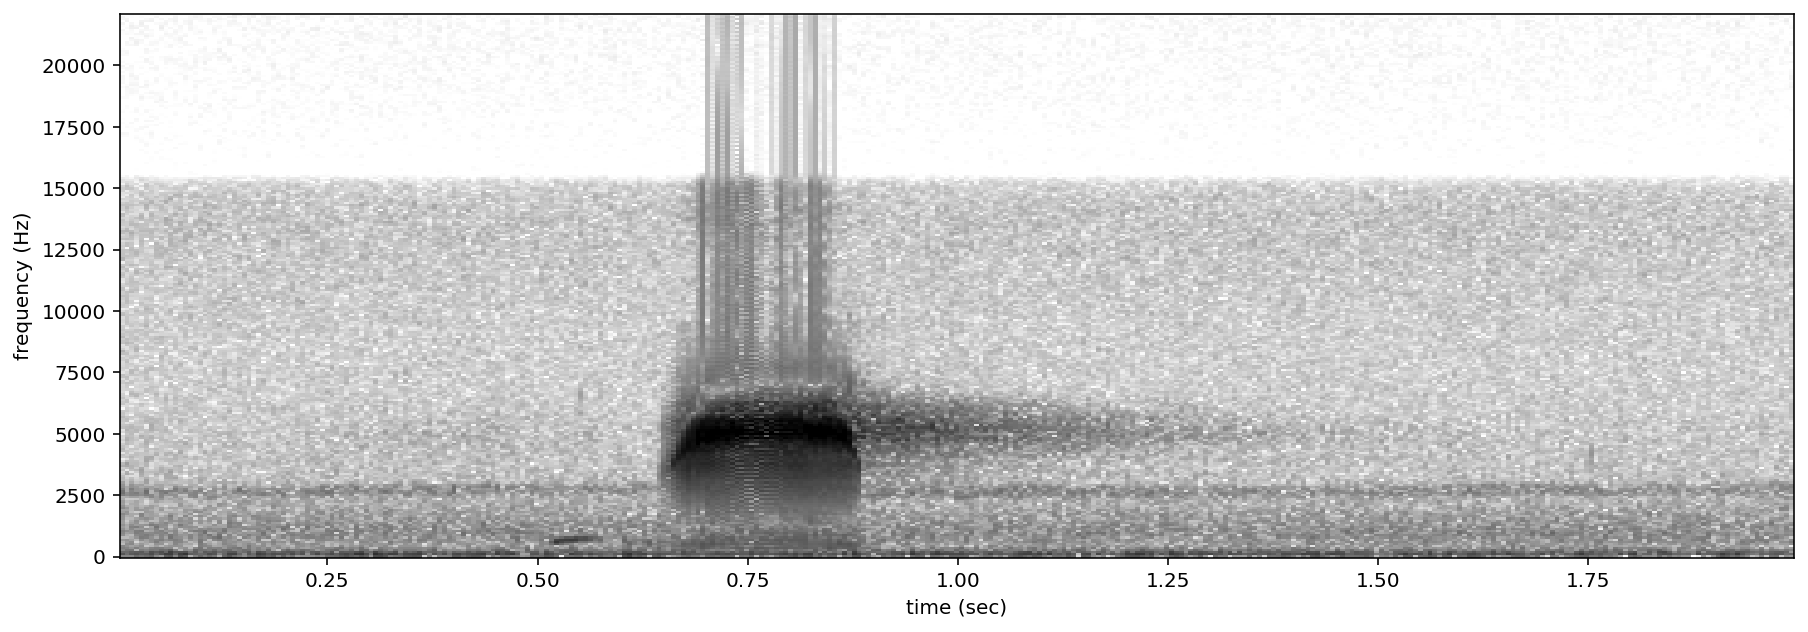

In [16]:
#initialize a preprocessor
preprocessor = AudioToSpectrogramPreprocessor(labels)
print('original pipeline:')
[print(p) for p in preprocessor.pipeline]

#overwrite the pipeline with a slice of the original pipeline
print('\nnew pipeline:')
preprocessor.pipeline = preprocessor.pipeline[0:3]

[print(p) for p in preprocessor.pipeline]

print('\nwe now have a preprocessor that returns Spectrograms instead of Tensors:')
print(type(preprocessor[0]['X']))
preprocessor[0]['X'].plot()

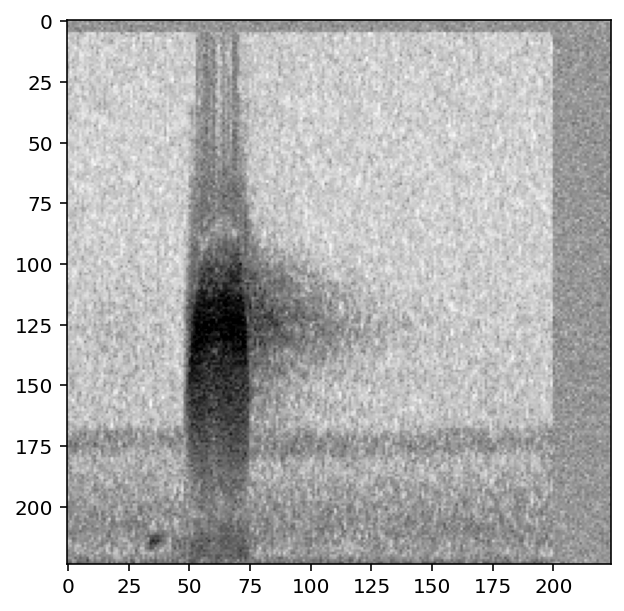

In [17]:
#initialize a preprocessor
preprocessor = CnnPreprocessor(labels)

#add a new Action to the Action container
from opensoundscape.preprocess.actions import TensorAddNoise
preprocessor.actions.add_noise_2 = TensorAddNoise(std=0.1)

#overwrite the pipeline with a list of Actions from .actions
preprocessor.pipeline = [
    preprocessor.actions.load_audio,
    preprocessor.actions.trim_audio,
    preprocessor.actions.to_spec,
    preprocessor.actions.bandpass,
    preprocessor.actions.to_img,
    preprocessor.actions.to_tensor,
    preprocessor.actions.normalize,
    preprocessor.actions.add_noise,
    preprocessor.actions.random_affine,
    preprocessor.actions.add_noise_2
]

show_tensor(preprocessor[0])

In [18]:
#initialize a preprocessor that includes augmentation
preprocessor = CnnPreprocessor(labels)

# Insert another instance of the "add_noise" action into the pipeline
preprocessor.pipeline.insert(-2, preprocessor.actions.add_noise)
preprocessor.pipeline

In [19]:
from opensoundscape.preprocess.actions import TensorAddNoise
class MyPreprocessor(AudioToSpectrogramPreprocessor):
    """Child of AudioToSpectrogramPreprocessor with weird augmentation routine"""

    def __init__(
        self,
        df,
        magic_parameter,
        audio_length=None,
        return_labels=True,
        out_shape=[224, 224],
    ):

        super(MyPreprocessor, self).__init__(
            df,
            audio_length=audio_length,
            out_shape=out_shape,
            return_labels=return_labels,
        )

        self.actions.add_noise = TensorAddNoise(std=0.1*magic_parameter)

        self.pipeline = [
            self.actions.load_audio,
            self.actions.trim_audio,
            self.actions.to_spec,
            self.actions.bandpass,
            self.actions.to_img,
            self.actions.to_tensor,
            self.actions.normalize,
        ] + [self.actions.add_noise for i in range(magic_parameter)]

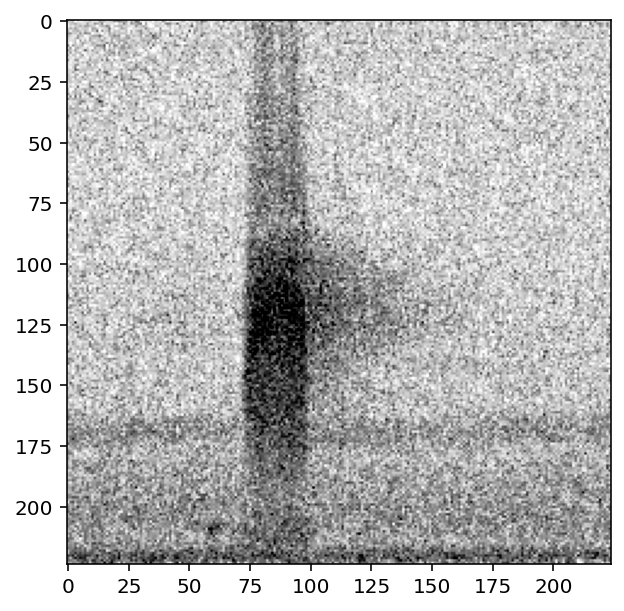

In [20]:
p = MyPreprocessor(labels, magic_parameter=2)
show_tensor(p[0])

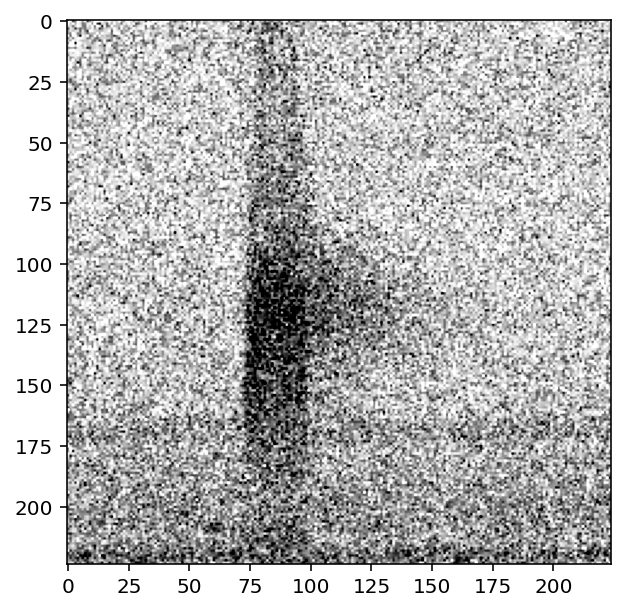

In [21]:
p = MyPreprocessor(labels, magic_parameter=3)
show_tensor(p[0])

You will need to define a .`go()` method for all actions. If you provide default parameter values, you will also need to define an `__init__()` method.

In [23]:
from opensoundscape.preprocess.actions import BaseAction
class SquareSamples(BaseAction):
    """Square values of every audio sample

    Audio in, Audio out
    """
    def go(self, audio):
        samples = np.array(audio.samples)**2
        return Audio(samples, audio.sample_rate)

In [24]:
from opensoundscape.audio import Audio

square_action = SquareSamples(threshold=0.2)

audio = Audio.from_file('./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav')
print(np.mean(audio.samples))
audio = square_action.go(audio)
print(np.mean(audio.samples))

0.012753859
0.008748752


In [25]:
import shutil
shutil.rmtree('./woodcock_labeled_data')